In [7]:
# Imports 

import numpy as np
import scipy
from scipy.special import erf
from matplotlib import pyplot as plt
from mpl_toolkits import mplot3d
from scipy.special import factorial2 as fact2
#import basis_set_exchange as bse

In [8]:
class BasisFunction:
    ''' A class that contains all our basis function data
            Attributes:
            origin: array/list containing the coordinates of the Gaussian origin
            shell:  tuple of angular momentum
            exps:   list of primitive Gaussian exponents
            coefs:  list of primitive Gaussian coefficients
            norm:   list of normalization factors for Gaussian primitives
    '''
    def __init__(self,origin=[0.0,0.0,0.0],shell=(0,0,0),exps=[],coefs=[]): 
        self.origin = np.asarray(origin)
        self.shell = shell
        self.exps = exps
        self.coefs = coefs
        self.norm = None
        self.normalize()
        
    def normalize(self):
        ''' Routine to normalize the basis functions, in case they
                    do not integrate to unity.
                '''
        l,m,n = self.shell
        L = l+m+n
        # self.norm is a list of length equal to number primitives 
        # normalize primitives first (PGBFs)
        self.norm = np.sqrt(np.power(2,2*(l+m+n)+1.5)*\
                            np.power(self.exps,l+m+n+1.5)/fact2(2*l-1)/fact2(2*m-1)/fact2(2*n-1)/np.power(np.pi,1.5))
        # now normalize the contracted basis functions (CGBFs) # Eq. 1.44 of Valeev integral whitepaper
        prefactor = np.power(np.pi,1.5)*\
                fact2(2*l - 1)*fact2(2*m - 1)*fact2(2*n - 1)/np.power(2.0,L)
        N = 0.0
        num_exps = len(self.exps) 
        for ia in range(num_exps):
            for ib in range(num_exps):
                N += self.norm[ia]*self.norm[ib]*self.coefs[ia]*self.coefs[ib]/np.power(self.exps[ia] + self.exps[ib],L+1.5)
        N *= prefactor
        N = np.power(N,-0.5)
        for ia in range(num_exps):
            self.coefs[ia] *= N
            
    def basisfcn_matrix(self,xdom,ydom,zdom):
        ''' Method that returns a 3-dimensional matrix corresponding to the 
            3D basis function evaluated in space on over a domain (xdom,ydom,zdom)
        '''
        l,m,n = self.shell
        xi = self.exps  
        G = np.zeros((len(xdom),len(ydom),len(zdom)))
        for i in range(len(xi)):
            gauss_x = xdom**l*np.exp(-xi[i]*xdom**2)
            gauss_y = ydom**m*np.exp(-xi[i]*ydom**2)
            gauss_z = zdom**n*np.exp(-xi[i]*zdom**2)
            Temp = np.kron(gauss_z,np.kron(gauss_y,gauss_x))
            G += self.coefs[i]*np.reshape(Temp,[len(xdom),len(ydom),len(zdom)])
            
        return G
            
            
            

In [9]:
def E(i,j,t,Qx,a,b):
    ''' Recursive definition of Hermite Gaussian coefficients.
            Returns a float.
            a: orbital exponent on Gaussian 'a' (e.g. alpha in the text)
            b: orbital exponent on Gaussian 'b' (e.g. beta in the text)
            i,j: orbital angular momentum number on Gaussian 'a' and 'b'
            t: number nodes in Hermite (depends on type of integral,
               e.g. always zero for overlap integrals)
            Qx: distance between origins of Gaussian 'a' and 'b'
    '''
    p=a+b
    q = a*b/p
    if (t < 0) or (t > (i + j)): # out of bounds for t
        return 0.0
    elif i == j == t == 0: # base case
        return np.exp(-q*Qx*Qx) # K_AB 
    elif j == 0: # decrement index i
        return (1/(2*p))*E(i-1,j,t-1,Qx,a,b) -  (q*Qx/a)*E(i-1,j,t,Qx,a,b) +  (t+1)*E(i-1,j,t+1,Qx,a,b)
    else: # decrement index j
        return (1/(2*p))*E(i,j-1,t-1,Qx,a,b) +  (q*Qx/b)*E(i,j-1,t,Qx,a,b) +  (t+1)*E(i,j-1,t+1,Qx,a,b)
            
def overlap(a,lmn1,A,b,lmn2,B):
    ''' Evaluates overlap integral between two Gaussians
            Returns a float.
            a:    orbital exponent on Gaussian 'a' (e.g. alpha in the text)
            b:    orbital exponent on Gaussian 'b' (e.g. beta in the text)
            lmn1: int tuple containing orbital angular momentum (e.g. (1,0,0))
                  for Gaussian 'a'
            lmn2: int tuple containing orbital angular momentum for Gaussian 'b'
            A:    list containing origin of Gaussian 'a', e.g. [1.0, 2.0, 0.0]
            B:    list containing origin of Gaussian 'b'
    '''
    l1,m1,n1 = lmn1 # shell angular momentum on Gaussian 'a' 
    l2,m2,n2 = lmn2 # shell angular momentum on Gaussian 'b' 
    S1 = E(l1,l2,0,A[0]-B[0],a,b) # X
    S2 = E(m1,m2,0,A[1]-B[1],a,b) # Y
    S3 = E(n1,n2,0,A[2]-B[2],a,b) # Z
    return S1*S2*S3*np.power(np.pi/(a+b),1.5)

def kinetic(a,lmn1,A,b,lmn2,B):
    ''' Evaluates kinetic energy integral between two Gaussians
            Returns a float.
            a:    orbital exponent on Gaussian 'a' (e.g. alpha in the text)
            b:    orbital exponent on Gaussian 'b' (e.g. beta in the text)
            lmn1: int tuple containing orbital angular momentum (e.g. (1,0,0))
                  for Gaussian 'a'
            lmn2: int tuple containing orbital angular momentum for Gaussian 'b'
            A:    list containing origin of Gaussian 'a', e.g. [1.0, 2.0, 0.0]
            B:    list containing origin of Gaussian 'b'
    '''
    
    l1,m1,n1 = lmn1
    l2,m2,n2 = lmn2
    
    term0 = b*(2*(l2+m2+n2)+3)*overlap(a,(l1,m1,n1),A,b,(l2,m2,n2),B)
    
    term1 = -2*np.power(b,2)*(overlap(a,(l1,m1,n1),A,b,(l2+2,m2,n2),B) +
                            overlap(a,(l1,m1,n1),A,b,(l2,m2+2,n2),B) +
                            overlap(a,(l1,m1,n1),A,b,(l2,m2,n2+2),B))
    
    term2 = -0.5*(l2*(l2-1)*overlap(a,(l1,m1,n1),A,b,(l2-2,m2,n2),B) +
                  m2*(m2-1)*overlap(a,(l1,m1,n1),A,b,(l2,m2-2,n2),B) +
                  n2*(n2-1)*overlap(a,(l1,m1,n1),A,b,(l2,m2,n2-2),B)) 
    
    return term0+term1+term2

def R(t,u,v,n,p,PCx,PCy,PCz,RPC):
    ''' Returns the Coulomb auxiliary Hermite integrals
            Returns a float.
            Arguments:
            t,u,v:   order of Coulomb Hermite derivative in x,y,z
                     (see defs in Helgaker and Taylor)
            n:       order of Boys function
            PCx,y,z: Cartesian vector distance between Gaussian
                     composite center P and nuclear center C
            RPC:     Distance between P and C
    '''
    T = p*RPC*RPC
    val = 0.0
    if t == u == v == 0:
        val += np.power(-2*p,n)*boys(n,T) 
    elif t == u == 0:
        if v > 1:
            val += (v-1)*R(t,u,v-2,n+1,p,PCx,PCy,PCz,RPC)
        val += PCz*R(t,u,v-1,n+1,p,PCx,PCy,PCz,RPC) 
    elif t == 0:
        if u > 1:
            val += (u-1)*R(t,u-2,v,n+1,p,PCx,PCy,PCz,RPC)
        val += PCy*R(t,u-1,v,n+1,p,PCx,PCy,PCz,RPC) 
    else:
        if t > 1:
            val += (t-1)*R(t-2,u,v,n+1,p,PCx,PCy,PCz,RPC)
        val += PCx*R(t-1,u,v,n+1,p,PCx,PCy,PCz,RPC) 
    return val

from scipy.special import hyp1f1
def boys(n,T):
    return hyp1f1(n+0.5,n+1.5,-T)/(2.0*n+1.0)

def gaussian_product_center(a,A,b,B): 
    return (a*A+b*B)/(a+b)

def nuclear_attraction(a,lmn1,A,b,lmn2,B,C):
    ''' Evaluates kinetic energy integral between two Gaussians
             Returns a float.
             a:    orbital exponent on Gaussian 'a' (e.g. alpha in the text)
             b:    orbital exponent on Gaussian 'b' (e.g. beta in the text)
             lmn1: int tuple containing orbital angular momentum (e.g. (1,0,0))
                   for Gaussian 'a'
             lmn2: int tuple containing orbital angular momentum for Gaussian 'b'
             A:    list containing origin of Gaussian 'a', e.g. [1.0, 2.0, 0.0]
             B:    list containing origin of Gaussian 'b'
             C:    list containing origin of nuclear center 'C'
    '''
    l1,m1,n1 = lmn1
    l2,m2,n2 = lmn2
    p=a+b
    P = gaussian_product_center(a,A,b,B) # Gaussian composite center 
    RPC = np.linalg.norm(P-C)
    val = 0.0
    for t in range(l1+l2+1):
        for u in range(m1+m2+1):
            for v in range(n1+n2+1):
                 val += E(l1,l2,t,A[0]-B[0],a,b) * E(m1,m2,u,A[1]-B[1],a,b) * E(n1,n2,v,A[2]-B[2],a,b) * \
                    R(t,u,v,0,p,P[0]-C[0],P[1]-C[1],P[2]-C[2],RPC)
    val *= 2*np.pi/p 
    return val

def electron_repulsion(a,lmn1,A,b,lmn2,B,c,lmn3,C,d,lmn4,D): 
    ''' Evaluates kinetic energy integral between two Gaussians
         Returns a float.
         a,b,c,d:   orbital exponent on Gaussian 'a','b','c','d'
         lmn1,lmn2
         lmn3,lmn4: int tuple containing orbital angular momentum
                    for Gaussian 'a','b','c','d', respectively
         A,B,C,D:   list containing origin of Gaussian 'a','b','c','d'
    '''
    l1,m1,n1 = lmn1
    l2,m2,n2 = lmn2
    l3,m3,n3 = lmn3
    l4,m4,n4 = lmn4
    p = a+b # composite exponent for P (from Gaussians 'a' and 'b') 
    q = c+d # composite exponent for Q (from Gaussians 'c' and 'd') 
    alpha = p*q/(p+q)
    P = gaussian_product_center(a,A,b,B) # A and B composite center 
    Q = gaussian_product_center(c,C,d,D) # C and D composite center 
    RPQ = np.linalg.norm(P-Q)
    val = 0.0
    for t in range(l1+l2+1):
        for u in range(m1+m2+1):
            for v in range(n1+n2+1):
                for tau in range(l3+l4+1): 
                    for nu in range(m3+m4+1):
                        for phi in range(n3+n4+1):
                            val += E(l1,l2,t,A[0]-B[0],a,b) * \
                                    E(m1,m2,u,A[1]-B[1],a,b) * \
                                    E(n1,n2,v,A[2]-B[2],a,b) * \
                                    E(l3,l4,tau,C[0]-D[0],c,d) * \
                                    E(m3,m4,nu ,C[1]-D[1],c,d) * \
                                    E(n3,n4,phi,C[2]-D[2],c,d) * \
                                    np.power(-1,tau+nu+phi) * \
                                    R(t+tau,u+nu,v+phi,0,\
                                        alpha,P[0]-Q[0],P[1]-Q[1],P[2]-Q[2],RPQ)
    val *= 2*np.power(np.pi,2.5)/(p*q*np.sqrt(p+q)) 
    return val

In [10]:
def S(a,b):
    '''Evaluates overlap between two contracted Gaussians
           Returns float.
           Arguments:
           a: contracted Gaussian 'a', BasisFunction object
           b: contracted Gaussian 'b', BasisFunction object
    '''
    s = 0.0
    for ia, ca in enumerate(a.coefs):
        for ib, cb in enumerate(b.coefs):
            s += a.norm[ia]*b.norm[ib]*ca*cb*\
                 overlap(a.exps[ia],a.shell,a.origin,
                 b.exps[ib],b.shell,b.origin)
    return s

def T(a,b):
    '''Evaluates kinetic energy between two contracted Gaussians
           Returns float.
           Arguments:
           a: contracted Gaussian 'a', BasisFunction object
           b: contracted Gaussian 'b', BasisFunction object
    '''
    t = 0.0
    for ia, ca in enumerate(a.coefs):
        for ib, cb in enumerate(b.coefs):
            t += a.norm[ia]*b.norm[ib]*ca*cb*kinetic(a.exps[ia],a.shell,a.origin,b.exps[ib],b.shell,b.origin)
    return t

def V(a,b,C,Z):
    '''Evaluates overlap between two contracted Gaussians
            Returns float.
            Arguments:
            a: contracted Gaussian 'a', BasisFunction object
            b: contracted Gaussian 'b', BasisFunction object
            C: center of nucleus
    '''
    v = 0.0
    for ia, ca in enumerate(a.coefs):
        for ib, cb in enumerate(b.coefs):
            v += a.norm[ia]*b.norm[ib]*ca*cb*nuclear_attraction(a.exps[ia],a.shell,a.origin,b.exps[ib],b.shell,b.origin,C)
    return -v*Z

def ERI(a,b,c,d):
    '''Evaluates overlap between two contracted Gaussians
            Returns float.
            Arguments:
            a: contracted Gaussian 'a', BasisFunction object
            b: contracted Gaussian 'b', BasisFunction object
            c: contracted Gaussian 'b', BasisFunction object
            d: contracted Gaussian 'b', BasisFunction object
    '''
    eri = 0.0
    for ja, ca in enumerate(a.coefs):
        for jb, cb in enumerate(b.coefs):
            for jc, cc in enumerate(c.coefs):
                for jd, cd in enumerate(d.coefs):
                    eri += a.norm[ja]*b.norm[jb]*c.norm[jc]*d.norm[jd]*\
                           ca*cb*cc*cd*\
                           electron_repulsion(a.exps[ja],a.shell,a.origin,\
                                b.exps[jb],b.shell,b.origin,\
                                c.exps[jc],c.shell,c.origin,\
                                d.exps[jd],d.shell,d.origin)
    return eri

In [11]:
def chemtophys(VVmat):
    n = VVmat.shape[0]
    VVmatph = np.zeros((n,n,n,n))
    for i in range(n):
        for j in range(n):
            for k in range(n):
                for l in range(n):
                    VVmatph[i,j,k,l] = VVmat[i,k,j,l]
    return VVmatph

def calcRHFenergy(C,Hcore,VVmat,Nelec):
    one_body = 0; two_body = 0; Norb = Hcore.shape[0]; Nocc = int(Nelec/2);
    Hcore_mo = C.T@Hcore@C
    C2 = np.kron(C,C); C2t = np.kron(C.T,C.T);
    VVmat_mo = np.reshape(C2t@np.reshape(VVmat,[Norb**2,Norb**2])@C2,[Norb,Norb,Norb,Norb])
    for i in range(Nocc):
        one_body += Hcore_mo[i,i]
        for j in range(Nocc):
            two_body += 2*VVmat_mo[i,j,i,j] - VVmat_mo[i,j,j,i]
    return 2*one_body + two_body

# def calcUHFenergy(C,Hcore,VVmat,Nalpha,Nbeta):
#     Norb = Hcore.shape[0]; Hcore_mo = [None]*2; VVmat_mo = [None]*3;
    
#     Hcore_mo[0] = C[0].T@Hcore@C[0]; Hcore_mo[1] = C[1].T@Hcore@C[1];
    
#     C21 = np.kron(C[0],C[0]); C2t1 = np.kron(C[0].T,C[0].T);
#     VVmat_mo[0] = np.reshape(C2t1@np.reshape(VVmat,[Norb**2,Norb**2])@C21,[Norb,Norb,Norb,Norb])
    
#     C22 = np.kron(C[1],C[1]); C2t2 = np.kron(C[1].T,C[1].T);
#     VVmat_mo[1] = np.reshape(C2t2@np.reshape(VVmat,[Norb**2,Norb**2])@C22,[Norb,Norb,Norb,Norb])
    
#     VVmat_mo[2] = np.reshape(C2t1@np.reshape(VVmat,[Norb**2,Norb**2])@C22,[Norb,Norb,Norb,Norb])

#     one_body = 0; two_body = 0; 
#     for i in range(Nalpha):
#         one_body += Hcore_mo[0][i,i]
#         for j in range(Nalpha):
#             two_body += 1/2*(VVmat_mo[0][i,j,i,j] - VVmat_mo[0][i,j,j,i])
            
#     for j in range(Nbeta):
#         one_body += Hcore_mo[1][i,i]
#         for j in range(Nbeta):
#             two_body += 1/2*(VVmat_mo[1][i,j,i,j]-VVmat_mo[1][i,j,j,i])
            
#     for i in range(Nalpha):
#         for j in range(Nbeta):
#             two_body += VVmat_mo[2][i,j,i,j]
            
#     return one_body + two_body

def calcUHFenergy(Hcore,Fock,P):
    energy = np.einsum('pq,pq->', (P[0] + P[1]), Hcore, optimize=True)
    energy += np.einsum('pq,pq->', P[0], Fock[0], optimize=True)
    energy += np.einsum('pq,pq->', P[1], Fock[1], optimize=True)
    energy *= 0.5
    return energy

def density_matrix_diff(Ptilde,P):
    B = P.shape[0]
    x = 0
    for i in range(B):
        for j in range(B):
            x += B**-2*(Ptilde[i,j]-P[i,j])**2
    
    return x**0.5

def calc_nuclear_nuclear(atom_coordinates,Z):
    Vnn = 0.0
    Nat = len(atom_coordinates)
    for i in range(Nat):
        for j in range(Nat):
            if i != j:
                Ri = np.asarray(atom_coordinates[i][:])
                Rj = np.asarray(atom_coordinates[j][:])
                Vnn += Z[i]*Z[j]/np.linalg.norm(Ri-Rj)
    return Vnn/2

def orthomat(S,tol,kind):
    evalS, U = np.linalg.eigh(S)
    diagS_minushalf = np.diag(evalS**(-0.5))
    if kind == 'symmetric':
        X0 = np.dot(U,np.dot(diagS_minushalf,U.T))
    else:
        X0 = np.dot(U,diagS_minushalf)
        
    idX = [i for i in range(S.shape[0])]
    for i in range(S.shape[0]):
        for j in range(i+1,S.shape[0]):
            if np.abs(evalS[i]-evalS[j]) < tol:
                J = idX.index(j)
                idX.remove(J)
    X = X0[:,idX]
    return X

def calc_density_matrix_rhf(C_sorted, Nelec):
    Pmat = np.zeros((C_sorted.shape[0],C_sorted.shape[1]))
    for i in range(C_sorted.shape[0]):
        for j in range(C_sorted.shape[0]):
            for a in range(int(Nelec/2)):
                Pmat[i,j] += 2*C_sorted[i,a]*C_sorted[j,a]
    return Pmat

def calc_density_matrix_uhf(C_sorted, Nalpha, Nbeta):
#     Pmat = [None]*2; Norb = C_sorted[0].shape[0];
#     Pmat[0] = np.zeros((Norb,Norb)); Pmat[1] = np.zeros((Norb,Norb));   
#     for i in range(Norb):
#         for j in range(Norb):
#             for a in range(Nalpha):
#                 Pmat[0][i,j] += C_sorted[0][i,a]*C_sorted[0][j,a]
#             for b in range(Nbeta):
#                 Pmat[1][i,j] += C_sorted[1][i,b]*C_sorted[1][j,b]
#     return Pmat
    return [np.einsum('ia,ja->ij',C_sorted[0][:,:Nalpha],C_sorted[0][:,:Nalpha]), \
            np.einsum('ia,ja->ij',C_sorted[1][:,:Nbeta] ,C_sorted[1][:,:Nbeta])]

def construct_orbitals(SHELL, XI, CM, atom_coordinates):
    orbs = []; Nat = len(SHELL);
    for i in range(Nat):
        for j in range(len(XI[i])):
            orbs.append(BasisFunction(origin=atom_coordinates[i][:],shell=SHELL[i][j],exps=XI[i][j],coefs=CM[i][j]))
    return orbs

In [14]:
basis = '6-31g'

# Obtain the basis set in nwchem format (as a string) for hydrogen and carbon
#BS = bse.get_basis(basis, elements=[1], fmt='gamess_us',header=False)
#print(BS)

if basis == '6-31g':
    shell_A = [(0,0,0),(0,0,0)]
    xi_A = [[0.1873113696E+02, 0.2825394365E+01, 0.6401216923E+00 ],[0.1612777588E+00]]
    Cm_A = [[0.3349460434E-01, 0.2347269535E+00, 0.8137573261E+00],[1.0000000]]
    shell_B = [(0,0,0),(0,0,0)]
    xi_B = [[0.1873113696E+02, 0.2825394365E+01, 0.6401216923E+00 ],[0.1612777588E+00]]
    Cm_B = [[0.3349460434E-01, 0.2347269535E+00, 0.8137573261E+00],[1.0000000]]
elif basis == 'sto-6g':
    shell_A = [(0,0,0)]
    xi_A = [[0.3552322122E+02, 0.6513143725E+01, 0.1822142904E+01, 0.6259552659E+00, 0.2430767471E+00, 0.1001124280E+00]]
    Cm_A = [[0.9163596281E-02, 0.4936149294E-01, 0.1685383049E+00, 0.3705627997E+00, 0.4164915298E+00, 0.1303340841E+00]]
    shell_B = [(0,0,0)]
    xi_B = [[0.3552322122E+02, 0.6513143725E+01, 0.1822142904E+01, 0.6259552659E+00, 0.2430767471E+00, 0.1001124280E+00]]
    Cm_B = [[0.9163596281E-02, 0.4936149294E-01, 0.1685383049E+00, 0.3705627997E+00, 0.4164915298E+00, 0.1303340841E+00]]
elif basis == 'DZP':
    shell_A = [(0,0,0),(0,0,0),(1,0,0),(0,1,0),(0,0,1)]
    xi_A = [[19.2406, 2.89920, 0.65340],[0.17760],[1],[1],[1]]
    Cm_A = [[0.032828, 0.231208, 0.817238],[1],[1],[1],[1]]
    shell_B = [(0,0,0),(0,0,0),(1,0,0),(0,1,0),(0,0,1)]
    xi_B = [[19.2406, 2.89920, 0.65340],[0.17760],[1],[1],[1]]
    Cm_B = [[0.032828, 0.231208, 0.817238],[1],[1],[1],[1]]
else:
    shell_A = [(0,0,0)]
    xi_A = [[0.3425250914E+01, 0.6239137298E+00, 0.1688554040E+00]]
    Cm_A = [[0.1543289673E+00, 0.5353281423E+00, 0.4446345422E+00]]
    shell_B = [(0,0,0)]
    xi_B = [[0.3425250914E+01, 0.6239137298E+00, 0.1688554040E+00]]
    Cm_B = [[0.1543289673E+00, 0.5353281423E+00, 0.4446345422E+00]]


SHELL = [shell_A, shell_B]
XI = [xi_A,xi_B]
CM = [Cm_A,Cm_B]

In [15]:
RJ = np.linspace(0.8,8,200)
#RJ = [5]
EHF = np.zeros(len(RJ))
Enuc = np.zeros(len(RJ))
Etot = np.zeros(len(RJ))

Palpha_list = []; Pbeta_list = []; 
Calpha_list = []; Cbeta_list = []; 
Ealpha_list = []; Ebeta_list = [];
orbs_list = []; seig = [];

flag_print = True
flag_verbose = False

Nat = 2; Z = [1, 1]; 
Nelec = 2; 
Nalpha = 1; Nbeta = 1;
level_shift = 0.0;

for J in range(len(RJ)):

    atom_coordinates = [[0, 0, -RJ[J]/2],
                        [0, 0, RJ[J]/2]]
    
    # Construct atom-centered CGO basis functions
    orbs = []
    for i in range(Nat):
        for j in range(len(XI[i])):
            orbs.append(BasisFunction(origin=atom_coordinates[i][:],shell=SHELL[i][j],exps=XI[i][j],coefs=CM[i][j]))
    Norb = len(orbs)
    
    # Calculate spatial orbital matrices
    Smat = np.zeros((Norb,Norb))
    Tmat = np.zeros((Norb,Norb))
    Vmat = np.zeros((Norb,Norb))
    VVmat = np.zeros((Norb,Norb,Norb,Norb))

    for i in range(Norb):
        for j in range(Norb):
            Smat[i,j] = S(orbs[i],orbs[j])
            Tmat[i,j] = T(orbs[i],orbs[j])
            for k in range(Nat):
                Vmat[i,j] += V(orbs[i],orbs[j],atom_coordinates[k][:],Z[k])
            for l in range(Norb):
                for m in range(Norb):
                    VVmat[i,l,j,m] += ERI(orbs[i],orbs[j],orbs[l],orbs[m]) # physics notation
    
    # Form Hcore
    Hcore = Tmat + Vmat
    
    # Orthogonalization of basis
    X = orthomat(Smat,0.0,'symmetric')
#     evalS, U = np.linalg.eigh(Smat)
#     diagS_minushalf = np.diag(evalS**(-0.5))
#     X = dot(U,diagS_minushalf)
    
#    seig.append(evalS)
    
    # Initial guess at P
    if J < 2:
        P = [None]*2
        P[0] = np.zeros((Norb,Norb))
        P[1] = np.zeros((Norb,Norb)) + 1e-3*np.eye(Norb)
    else:
        P[0] = 0.5*(P[0] + Palpha_list[-2]); P[1] = 0.5*(P[1] + Pbeta_list[-2]);   

    # Iterative process
    tol_e=10**-9
    tol_p=10**-15
    flag_exit = False
    maxit = 500
    it = 1
    F_list = []
    DIIS_r = []
    
    G, Fock, C = [[None]*2,[None]*2,[None]*2]
    
    while (not flag_exit):
    
        # Calculate Fock matrix 
        Temp = np.einsum('prqs,rs->pq',VVmat,P[0]+P[1],optimize=True)
        G[0] = Temp-np.einsum('prsq,rs->pq',VVmat,P[0],optimize=True)
        G[1] = Temp-np.einsum('prsq,rs->pq',VVmat,P[1],optimize=True)
        Fock[0] = Hcore + G[0] + level_shift*(Smat-Smat*P[0]*Smat)
        Fock[1] = Hcore + G[1] + level_shift*(Smat-Smat*P[1]*Smat)

        # Calculate Fock matrix in orthogonalised base
        eps_alpha, Cp1 = np.linalg.eigh(np.dot(X.T,np.dot(Fock[0], X)))
        eps_beta, Cp2 = np.linalg.eigh(np.dot(X.T,np.dot(Fock[1], X)))
        
        idx1 = np.real(eps_alpha).argsort(); eps_alpha = eps_alpha[idx1];
        idx2 = np.real(eps_beta).argsort(); eps_beta = eps_beta[idx2]
        
        C[0] = np.dot(X,Cp1[:,idx1])
        C[1] = np.dot(X,Cp2[:,idx2])

        # Calculate new density matrices and energy
        P = calc_density_matrix_uhf(C,Nalpha,Nbeta)
        ehf = calcUHFenergy(Hcore,Fock,P)
        
        # Check loop exit condition
        if it > 1:
            dp1 = np.sqrt(np.mean(np.mean((P[0]-P_previous[0])**2)))
            dp2 = np.sqrt(np.mean(np.mean((P[1]-P_previous[1])**2)))
            de = abs(ehf - ehf_previous)
            dp = dp1 + dp2
            if dp <= tol_p and de <= tol_e:
                flag_exit = True
            elif it == maxit:
                flag_exit = True
            else:
                flag_exit = False
        
        P_previous = P.copy()
        ehf_previous= ehf.copy()
        
        if flag_verbose:
            print('R = {}: Iter-{}, E = {}'.format(RJ[J],it,ehf))
        
        it += 1
        
    Palpha_list.append(P[0])
    Pbeta_list.append(P[1]) 
    
    Calpha_list.append(C[0])
    Cbeta_list.append(C[1])
    
    Ealpha_list.append(eps_alpha)
    Ebeta_list.append(eps_beta)
    
    EHF[J] = ehf
    Enuc[J] = calc_nuclear_nuclear(atom_coordinates,Z)
    Etot[J] = EHF[J] + Enuc[J]
        
    if flag_print:
        if it < maxit:
            print('R = {} took {} iterations to converge'.format(RJ[J],it))
        else:
            print('R = {} SCF not converged in {} iterations'.format(RJ[J],it))
        

R = 0.8 took 40 iterations to converge
R = 0.8361809045226131 took 37 iterations to converge
R = 0.8723618090452262 took 19 iterations to converge
R = 0.9085427135678392 took 18 iterations to converge
R = 0.9447236180904524 took 18 iterations to converge
R = 0.9809045226130654 took 19 iterations to converge
R = 1.0170854271356784 took 18 iterations to converge
R = 1.0532663316582915 took 18 iterations to converge
R = 1.0894472361809044 took 18 iterations to converge
R = 1.1256281407035176 took 19 iterations to converge
R = 1.1618090452261307 took 18 iterations to converge
R = 1.1979899497487438 took 18 iterations to converge
R = 1.2341708542713568 took 18 iterations to converge
R = 1.2703517587939699 took 19 iterations to converge
R = 1.3065326633165828 took 18 iterations to converge
R = 1.342713567839196 took 18 iterations to converge
R = 1.378894472361809 took 18 iterations to converge
R = 1.4150753768844222 took 18 iterations to converge
R = 1.4512562814070353 took 18 iterations to 

R = 6.408040201005025 took 24 iterations to converge
R = 6.444221105527638 took 24 iterations to converge
R = 6.480402010050251 took 24 iterations to converge
R = 6.516582914572864 took 24 iterations to converge
R = 6.552763819095477 took 23 iterations to converge
R = 6.5889447236180905 took 23 iterations to converge
R = 6.625125628140703 took 24 iterations to converge
R = 6.661306532663316 took 23 iterations to converge
R = 6.697487437185929 took 23 iterations to converge
R = 6.733668341708542 took 23 iterations to converge
R = 6.769849246231155 took 23 iterations to converge
R = 6.806030150753768 took 23 iterations to converge
R = 6.8422110552763815 took 23 iterations to converge
R = 6.878391959798995 took 23 iterations to converge
R = 6.914572864321608 took 23 iterations to converge
R = 6.950753768844221 took 23 iterations to converge
R = 6.986934673366834 took 23 iterations to converge
R = 7.023115577889447 took 23 iterations to converge
R = 7.059296482412059 took 23 iterations to 

The bond length is 1.378894472361809 bohr
The bond energy is -1.1268277676681264 Ha


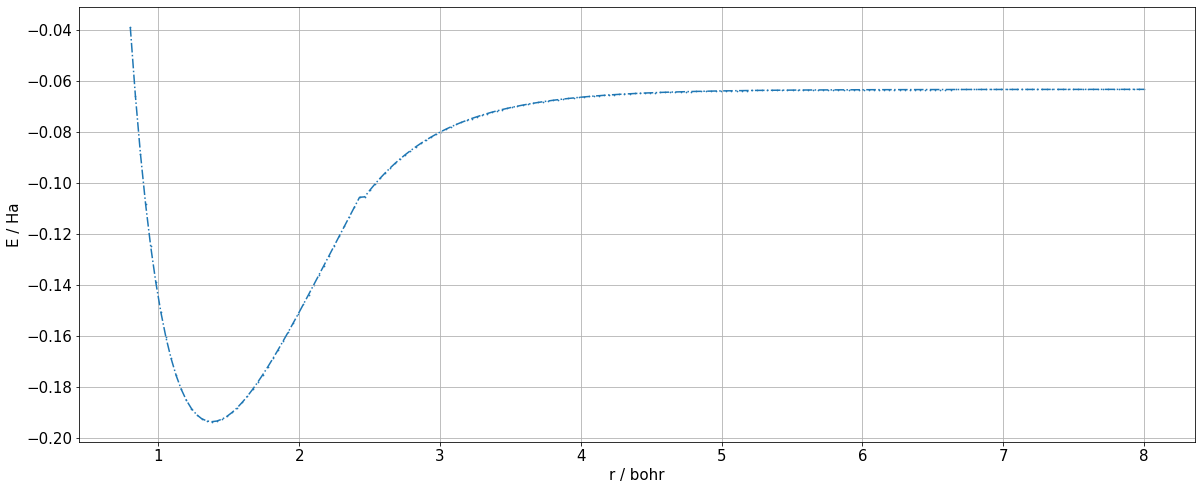

In [16]:
E0 = -0.4666

plt.rcParams.update({'font.size': 15})
fig = plt.figure(figsize = (20,8))
plt.plot(RJ,Etot-2*E0,'-.')
plt.scatter(RJ,Etot-2*E0,0.5,label='HF Energy')
#plt.plot(RJ,Ealpha,'-.')
#plt.scatter(RJ,Ealpha,label=r'$\alpha$ MO')
#plt.plot(RJ,Ebeta,'-.')
#plt.scatter(RJ,Ebeta,label=r'$\beta$ MO')
plt.grid(True)
plt.xlabel('r / bohr')
plt.ylabel('E / Ha')
#plt.legend(bbox_to_anchor=(1.005, 1),loc='upper left')

Ieq = np.argmin(Etot)
Req = RJ[Ieq]
Eeq = Etot[Ieq]

print('The bond length is {} bohr'.format(Req))
print('The bond energy is {} Ha'.format(Eeq))
# print('\n')
# print('The orbital energies are {} and {} Hartrees'.format(evalFockprime[0],evalFockprime[1]))
# print('\n')
# print(f'The orbital matrix is: \n\n{C}')
# print('\n')
# print(f'The density/bond order matrix is: \n\n{P}')

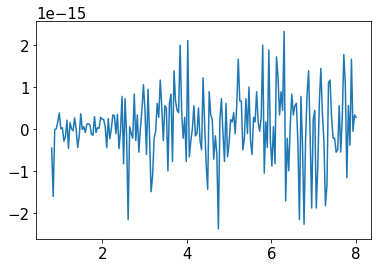

In [30]:
S2 = np.array(RJ)
for i in range(len(Palpha_list)):
    S2[i] = np.trace( (Palpha_list[i]-Pbeta_list[i]) )
    
plt.plot(RJ,S2)

In [12]:
#Cmat = np.zeros((Norb,Norb,len(RJ)))
Ealphamat = np.zeros((Norb,Norb,len(RJ)))
Pmatbeta = np.zeros((Norb,Norb,len(RJ)))
for i in range(len(RJ)):
    #Cmat[:,:,i] = Coeff_list[i]
    Pmatalpha[:,:,i] = Palpha_list[i]
    Pmatbeta[:,:,i] = Pbeta_list[i]
    
for i in range(Norb):
    for j in range(1):
        J = i;
        plt.plot(RJ,np.squeeze(Pmatbeta[i,J,:]),label=str(i+1)+str(J+1))
plt.legend(bbox_to_anchor=[1.005,0],loc='lower left')

NameError: name 'Pmatalpha' is not defined

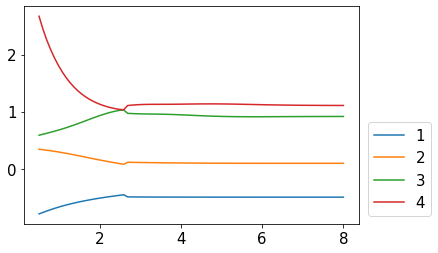

In [84]:
Ealpha = np.zeros((len(RJ),4))
Ebeta = np.zeros((len(RJ),4))
for i in range(len(RJ)):
    Ealpha[i,:] = Ealpha_list[i][:]
    Ebeta[i,:] = Ebeta_list[i][:Nbeta]

for i in range(4):
    plt.plot(RJ,Ealpha[:,i],label=str(i+1))
#plt.plot(RJ,Ebeta,label=r'$\beta$')
plt.legend(bbox_to_anchor=[1.005,0],loc='lower left')

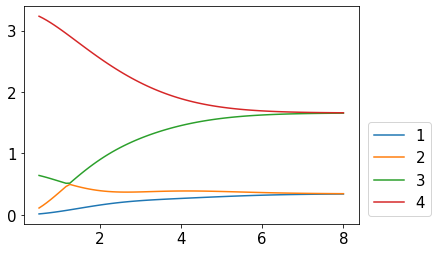

In [87]:
seigs = np.zeros((len(RJ),Norb))
for i in range(len(RJ)):
    seigs[i,:] = seig[i]
for i in range(4):
    plt.plot(RJ,seigs[:,i],label=str(i+1))
plt.legend(bbox_to_anchor=[1.005,0],loc='lower left')